In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
iris = load_iris()
X = iris.data
y = iris.target
f_names = iris.feature_names
t_names = iris.target_names
# Pandas DataFrame 생성
df = pd.DataFrame(data=X, columns=f_names)
df['target'] = y
df['target_names'] = [t_names[i] for i in y]
# 데이터프레임 출력 (처음 5행)
print(df.head())

   sepal length (cm)  sepal width (cm)  ...  target  target_names
0                5.1               3.5  ...       0        setosa
1                4.9               3.0  ...       0        setosa
2                4.7               3.2  ...       0        setosa
3                4.6               3.1  ...       0        setosa
4                5.0               3.6  ...       0        setosa

[5 rows x 6 columns]


In [ ]:
# 데이터 분할 (훈련 세트 80%, 테스트 세트 20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
# Random Forest 모델 생성
# 하이퍼파라미터 튜닝을 위해 GridSearchCV 사용
param_grid = {
    'n_estimators': [50,100,200],   # 트리 수
    'max_depth': [4,6,8],           # 트리 깊이
    'min_samples_split': [2,4],     # 노드를 분할할 최소 샘플 수
    'min_samples_leaf': [1,2]       # 마지막노드에 있어야할 최소 샘플 수
}
# Random Forest 모델 초기화
rf_model = RandomForestClassifier(random_state=42)
# 교차 검증 cv =3 : 훈련 데이터를 3개의 FOLD(묶음)으로 나누어서 두개를 훈련, 나머지는 검증 용도로 활용
# 교차 검증은 최적의 하이퍼 파라미터 값을 찾기 위해서 사용됨
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')
# 모델 학습 (GridSearchCV를 통한 최적의 파라미터를 반영한 학습)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [11]:
# 최적의 파라미터 출력
print(grid_search.best_params_)

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
# 최적의 모델 저장
best_rf_model = grid_search.best_estimator_
# 테스트 데이터로 예측 (하이퍼 파라미터 튜닝을 통해 최적회된 상태로 예측이 이루어짐)
y_pred = best_rf_model.predict(X_test)
# 정확도 평가
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.9666666666666667


In [13]:
# 분류 보고서
print(classification_report(y_test, y_pred, target_names=t_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



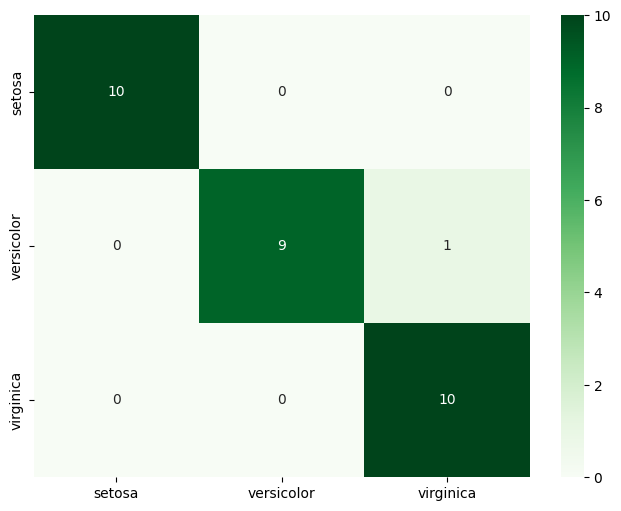

In [14]:
# 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
# annot=True : 각 셀안의 숫자값을 표시, fmt="d" : 숫자값을 정수형태로 표시, cmap="Blues" : 색상값은 블루
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=t_names, yticklabels=t_names)
plt.show()

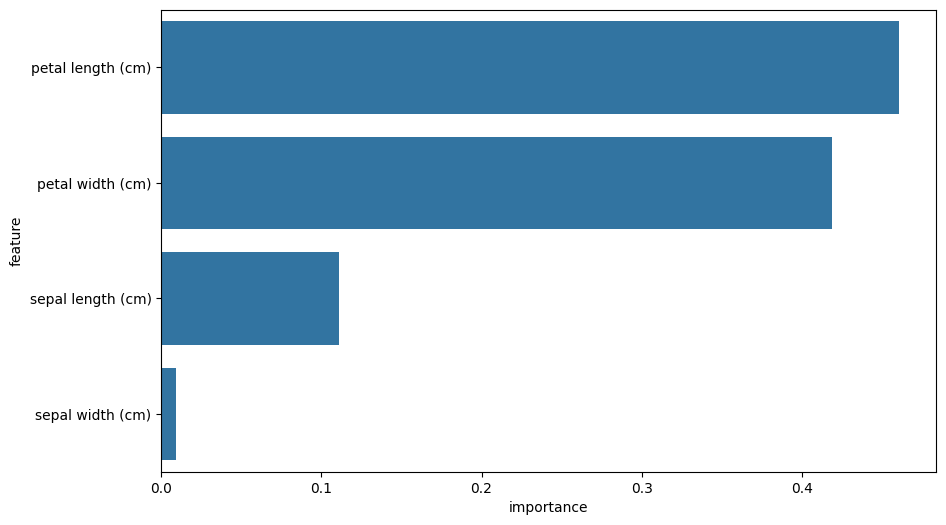

In [18]:
# Feature Importance 시각화
feature_importances = best_rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'feature':f_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance',ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.show()

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 불러오기
# encoding 방식 : utf-8(범용성), ISO-8859-1(서유럽), CP949(한글)
data = pd.read_csv('dataset/spam.csv', encoding='ISO-8859-1')

# 데이터 내용 미리보기 (처음 5개 행 출력)
print(data.head())
# 필요한 열만 선택
data = data[['v1','v2']]
data.columns = ['label','text']
# 열 이름 변경

     v1  ... Unnamed: 4
0   ham  ...        NaN
1   ham  ...        NaN
2  spam  ...        NaN
3   ham  ...        NaN
4   ham  ...        NaN

[5 rows x 5 columns]


In [22]:
# 2. 데이터 전처리
# 레이블을 숫자로 변환, map함수: 열의 각 값을 다른 값으로 변환하는 데 사용
data['label'] = data['label'].map({'ham':0,'spam':1})
# 결측치 제거
data.dropna(inplace=True)
# 3. 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['label'],test_size=0.2,random_state=42)
# 4. TF-IDF 벡터화(희소성 문자에 중요도)
# stop_words: 불필요한 영어 단어(예: "the", "is", "and" 등)를 자동으로 제거
vectorizer = TfidfVectorizer(stop_words='english')
# fit: 학습 데이터의 중요한 통계정보(단어빈도수)학습, transform: 숫자 벡터로 변환
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
# 5. 모델 학습
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [23]:
# 6. 예측 및 평가
y_pred = model.predict(X_test_tfidf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9668161434977578
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [24]:
# 7. 샘플 테스트
sample_text = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now!",
               "Congratulations! You've been selected to receive a free iPhone 15. Click to claim now!",
               "Hey, are we meeting for lunch tomorrow?"]
sample_tfidf = vectorizer.transform(sample_text)
predictions = model.predict(sample_tfidf)
for text,label in zip(sample_text,predictions):
    print(f"Text: {text} => {'Spam' if label==1 else 'Ham'}")

Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now! => Spam
Text: Congratulations! You've been selected to receive a free iPhone 15. Click to claim now! => Spam
Text: Hey, are we meeting for lunch tomorrow? => Ham


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 불러오기
data = pd.read_csv('dataset/spam.csv',encoding='ISO-8859-1')
# 필요한 열만 선택
data = data[['v1','v2']]
# 열 이름 변경
data.columns = ['label','text']

# 2. 데이터 전처리
# 레이블을 숫자로 변환
data['label'] = data['label'].map({'ham':0,'spam':1})
# 결측치 제거
data.dropna(inplace=True)

# 3. 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# 4. TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 5. SVM 모델 학습
model = SVC(kernel='linear',random_state=42)
model.fit(X_train_tfidf,y_train)

SVC(kernel='linear', random_state=42)

In [26]:
# 6. 예측 및 평가
y_pred = model.predict(X_test_tfidf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.979372197309417
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [27]:
# 7. 샘플 테스트
sample_text = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now!",
    "Congratulations! You've been selected to receive a free iPhone 15. Click to claim now!",
    "Hey, are we meeting for lunch tomorrow?"
]
sample_text_tfidf = vectorizer.transform(sample_text)
predictions = model.predict(sample_text_tfidf)
for text,label in zip(sample_text,predictions):
    print(f"Text: {text} => {'Spam' if label==1 else 'Ham'}")


Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 now! => Spam
Text: Congratulations! You've been selected to receive a free iPhone 15. Click to claim now! => Spam
Text: Hey, are we meeting for lunch tomorrow? => Ham


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False
# 데이터 로드
df = pd.read_csv('dataset/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
# 특성(X)과 타겟(y) 분리
# Outcome 열을 제외한 모든 특성
X = df.drop('Outcome', axis=1)
# 타겟 변수
y = df['Outcome']
# 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# 선형회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [30]:
# 테스트 세트에 대한 예측
y_pred = model.predict(X_test)
# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# 결과 출력
print(f"MSE:{mse:.4f}")
print(f"RMSE:{rmse:.4f}")
print(f"R2_Score:{r2:.4f}")

MSE:0.1710
RMSE:0.4136
R2_Score:0.2550


In [31]:
# 각 특성의 계수(가중치) 출력
feature_coefficients = pd.DataFrame({
    '특성':X.columns,
    '계수':model.coef_
})
print(feature_coefficients)

                         특성        계수
0               Pregnancies  0.010468
1                   Glucose  0.005634
2             BloodPressure -0.002281
3             SkinThickness  0.000532
4                   Insulin -0.000278
5                       BMI  0.015039
6  DiabetesPedigreeFunction  0.111263
7                       Age  0.006460


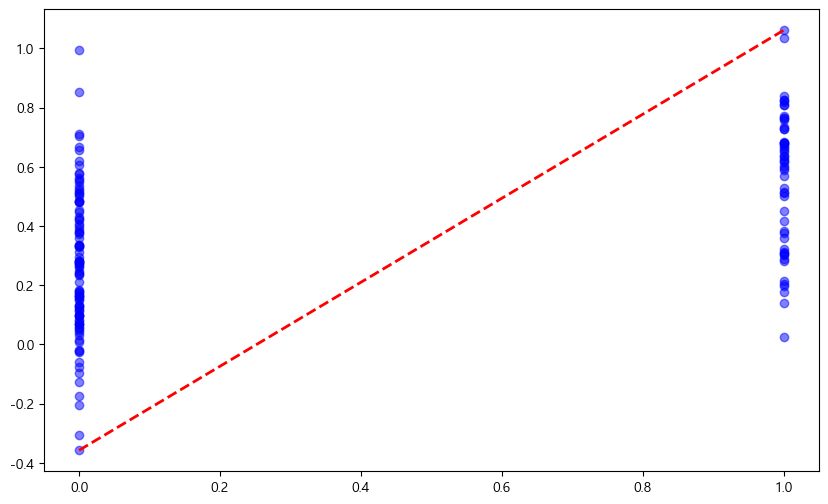

In [33]:
# 실제값과 예측값 비교 시각화
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred,color='blue',alpha=0.5)
plt.plot([y_test.min(),y_test.max()],[y_pred.min(),y_pred.max()],'r--',lw=2)
plt.show()

In [34]:
# 예시: 첫 번째 테스트 데이터에 대한 예측
sample_data = X_test.iloc[0:1]
prediction = model.predict(sample_data)
print(f"{prediction[0]:.4f}")
print(f"{sample_data.values[0]}")

0.3355
[  6.    98.    58.    33.   190.    34.     0.43  43.  ]


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
data = pd.read_csv("dataset/diabetes.csv")
# 특성(X)과 타겟(y) 분리
X = data.drop('Outcome', axis=1)
y = data['Outcome']
# 데이터 전처리: 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42)
# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [38]:
# 예측
y_pred = rf_model.predict(X_test)
# 교차 검증 수행
cv_scores = cross_val_score(rf_model,X_scaled,y,cv=5)
# 특성 중요도 계산
feature_importance = pd.DataFrame({
    "특성": X.columns,
    "중요도":rf_model.feature_importances_
}).sort_values('중요도',ascending=False)
# 결과 출력
print(f"{cv_scores.mean():.4f}({cv_scores.std()*2:.4f})")
print(classification_report(y_test,y_pred))

0.7644(0.0867)
              precision    recall  f1-score   support

           0       0.79      0.80      0.79        99
           1       0.63      0.62      0.62        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



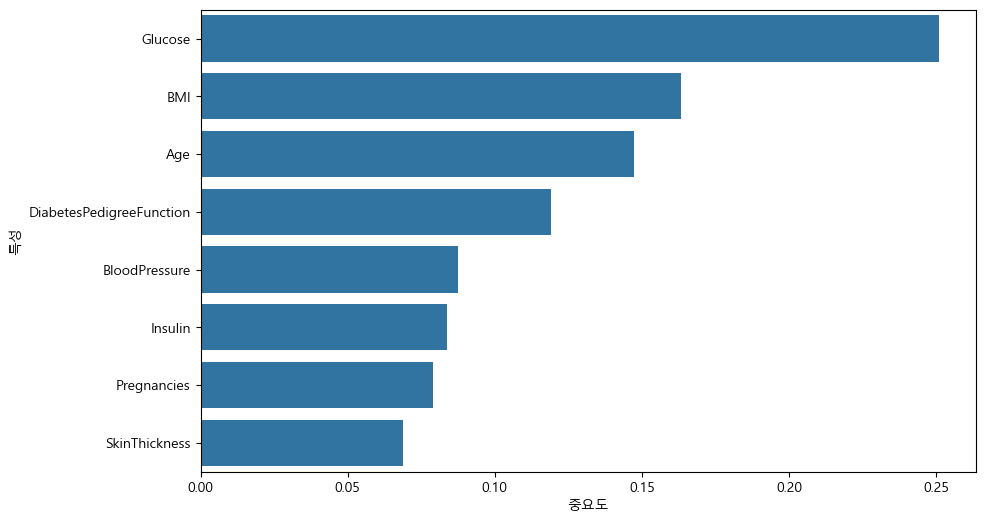

In [39]:
# 특성 중요도 시각화
plt.figure(figsize=(10,6))
sns.barplot(x='중요도',y='특성',data=feature_importance)
plt.show()

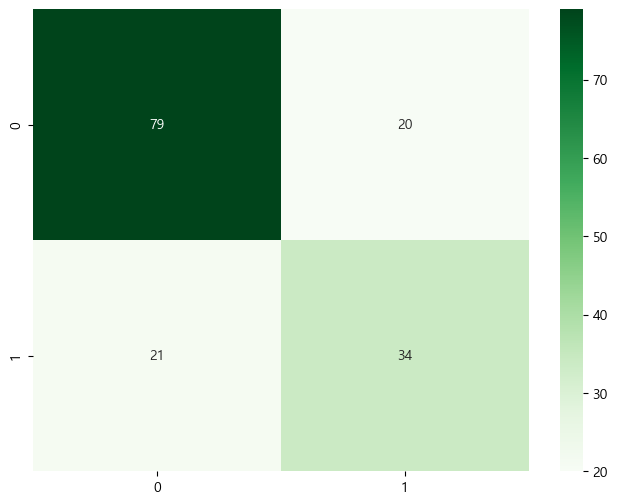

In [40]:
# 혼동 행렬 시각화
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap="Greens")
plt.show()

In [41]:
# 새로운 환자 데이터로 예측 예시
# 임의의 환자 데이터 생성
new_patient = X_test.iloc[0:1]
prediction = rf_model.predict(new_patient)
prediction_prob = rf_model.predict_proba(new_patient)

print(f"{'당뇨병환자' if prediction[0]==1 else '정상'}")
print(f"{prediction_prob[0][1]:.2f}")

정상
0.42



예측 신뢰도 분포:


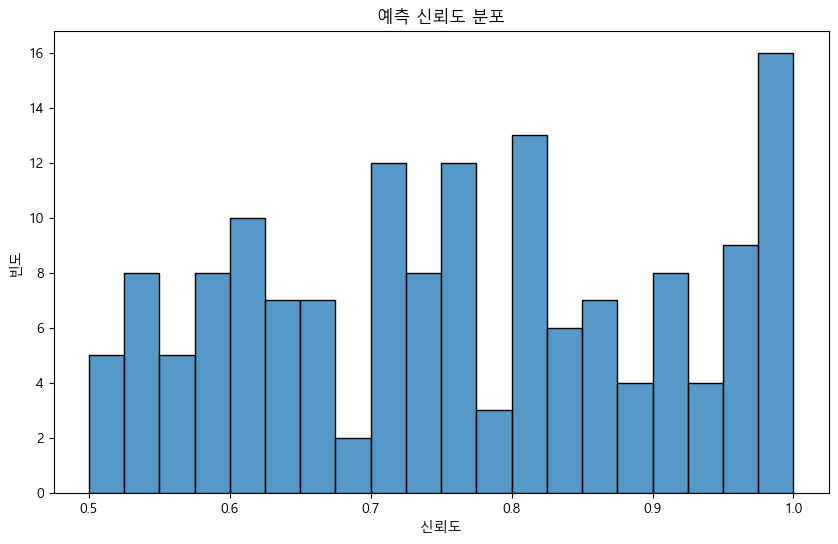

In [42]:
threshold_probs = rf_model.predict_proba(X_test)
confidence_scores = np.max(threshold_probs, axis=1)

print("\n예측 신뢰도 분포:")
plt.figure(figsize=(10, 6))
sns.histplot(confidence_scores, bins=20)  # bins=20 : 데이터를 20개의 구간으로 보여줌
plt.title('예측 신뢰도 분포')
plt.xlabel('신뢰도')
plt.ylabel('빈도')
plt.show()

In [44]:
### 컬럼 설명 ###
# CRIM(타운별 1인당 범죄울), ZN(25,000평방피트 주택이 차지하는 비율), INDUS(비소매 상업지역 면적비율)
# CHAS(찰스강 인접 여부), NOX(일산화질소 농도), RM(주택 1가구당 평균 방 개수), AGE(1940년대 이전 주택 비율)
# DIS(보스턴 고용 센터까지의 가중거리), TAX(10,000달러당 재산세율), PTRATIO(타운별 학생교사 비율)
# B(타운별 흑인인구 비율 계산식), LSTAT(하위 계층의 비율), MEDV(주택의 중간 가격)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 폰트지정
plt.rcParams["font.family"] = "Malgun Gothic"
# 마이너스 부호 깨짐 지정
plt.rcParams["axes.unicode_minus"] = False
# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format
# 데이터 로드
data = pd.read_csv("dataset/HousingData.csv")
# 데이터 확인
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1,296,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2,242,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2,242,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3,222,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3,222,18.70,396.90,NaN,36.20


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [48]:
# 결측값 확인 및 처리
print(data.isnull().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [50]:
# 결측값 제거
data = data.dropna()

In [51]:
# 결측값 확인 및 처리
print(data.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [56]:
# 주요 변수 선택
# 입력 변수: CRIM(범죄율), RM(방개수), TAX(세금), LSTAT(하위계층비율)
X = data[['CRIM','RM','TAX','LSTAT']]
# 타겟 변수 (집값)
y = data['MEDV']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"{mse}")
print(f"{r2}")

41.01145441904804
0.5137736507938266


In [60]:
# 회귀 계수 출력
print(model.coef_)
print(model.intercept_)

[-0.08498347  5.59693339 -0.00824347 -0.42511164]
-3.831014747888208


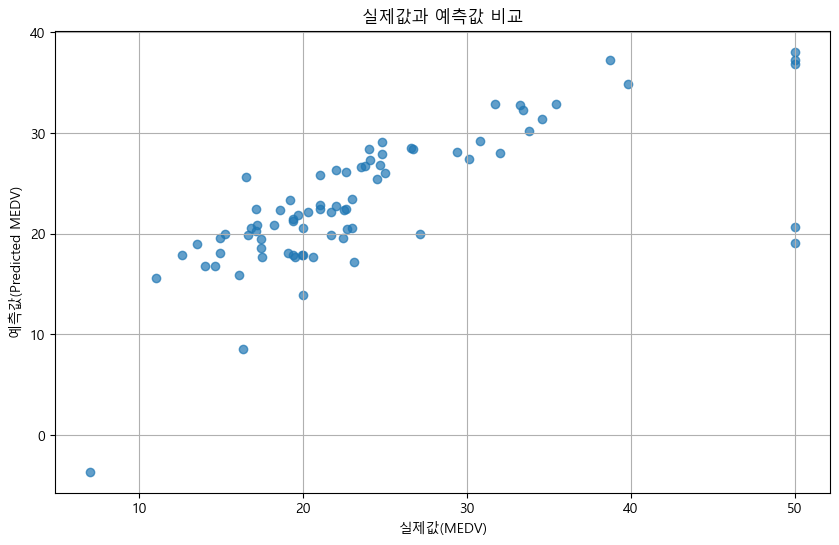

In [61]:
# 결과 시각화
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred, alpha=0.7)
plt.xlabel('실제값(MEDV)')
plt.ylabel('예측값(Predicted MEDV)')
plt.title('실제값과 예측값 비교')
plt.grid()
plt.show()

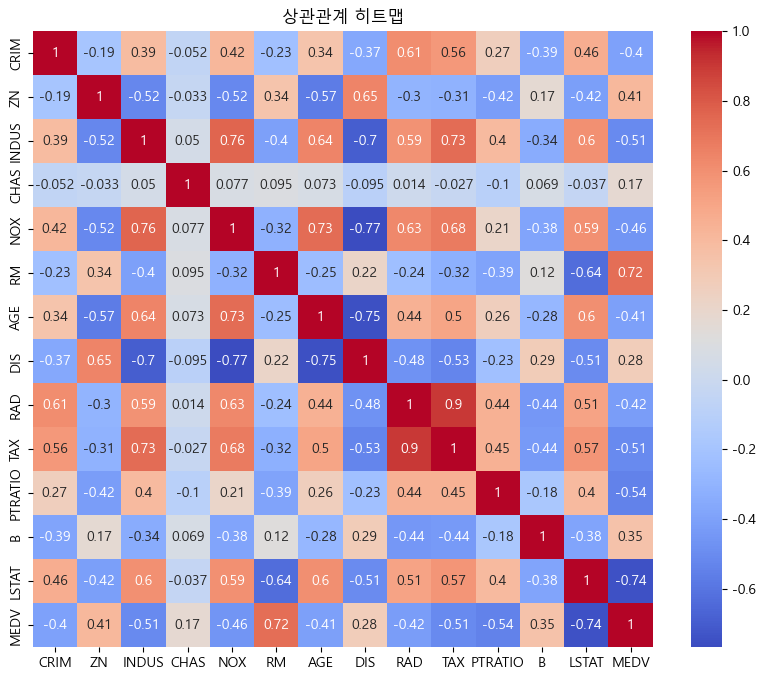

In [62]:
# 변수별 상관관계 히트맵
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('상관관계 히트맵')
plt.show()

In [71]:
X = data[['LSTAT','PTRATIO','TAX','INDUS']]
y = data['MEDV']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [72]:
# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"{mse}")
print(f"{r2}")

47.959607183856086
0.4313972756953056


In [73]:
# 회귀 계수 출력
print(model.coef_)
print(model.intercept_)

[-0.71989154 -1.28692261 -0.00160883 -0.06091623]
56.63575941201396


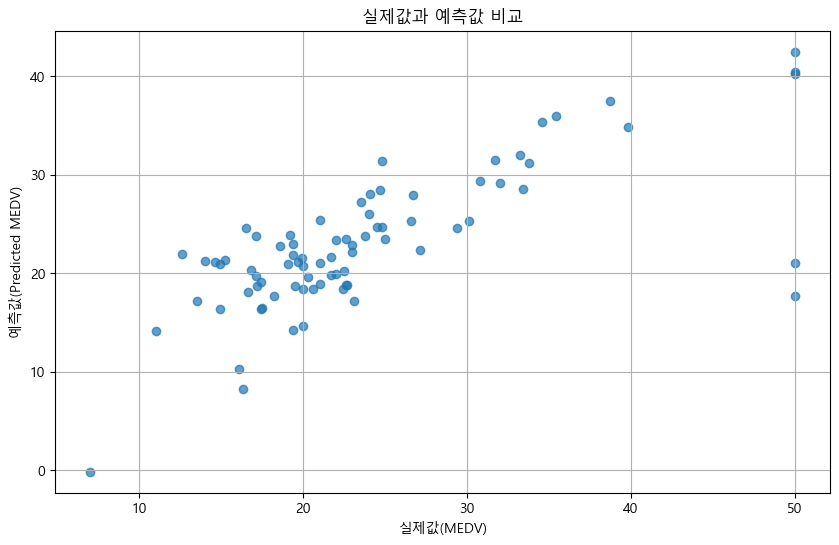

In [66]:
# 결과 시각화
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred, alpha=0.7)
plt.xlabel('실제값(MEDV)')
plt.ylabel('예측값(Predicted MEDV)')
plt.title('실제값과 예측값 비교')
plt.grid()
plt.show()

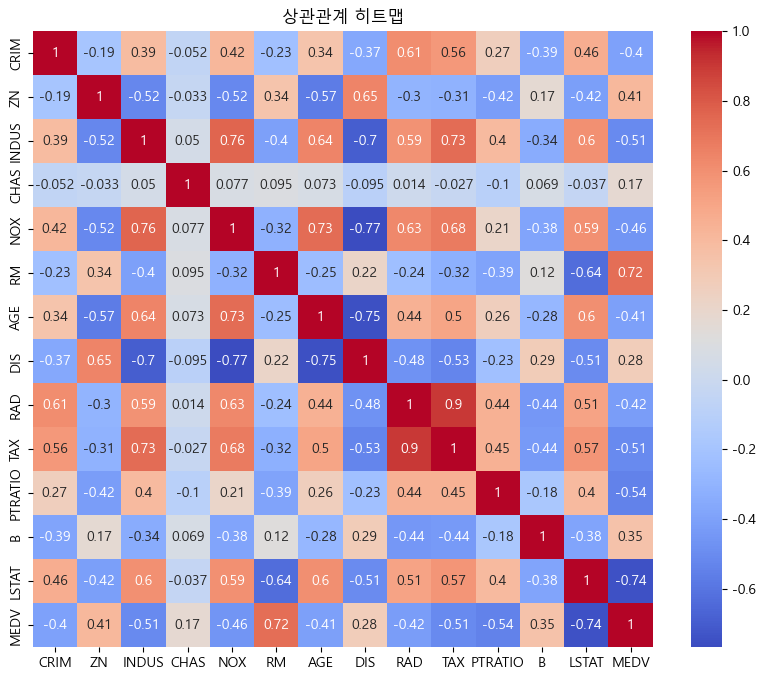

In [67]:
# 변수별 상관관계 히트맵
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('상관관계 히트맵')
plt.show()

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv("dataset/HousingData.csv")
# 데이터 전처리
data = data.dropna()
X = data[['CRIM','ZN','INDUS','RM','AGE','DIS','TAX','LSTAT']]
y = data['MEDV']
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# 1. 랜덤 포레스트 모델
rf_model = RandomForestRegressor(random_state=42,n_estimators=100)
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
# 랜덤 포레스트 평가
rf_mse = mean_squared_error(y_test,rf_pred)
rf_r2 = r2_score(y_test,rf_pred)
print(f"랜덤포레스트 - MSE:{rf_mse:.2f}, R2:{rf_r2:.2f}")

랜덤포레스트 - MSE:28.59, R2:0.66


In [91]:
# 2. 다른 모델 비교
models = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree" : DecisionTreeRegressor(random_state=42)
}

results = {}
#print(models.items())
#print(X_train.isnull().sum())
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    results[name] = {"MSE":mse,"R2":r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

Linear Regression - MSE: 36.34, R2: 0.57
Decision Tree - MSE: 27.30, R2: 0.68


In [94]:
# 3. 최적 모델 선택 및 시각화
results["Random Forest"] = {"MSE":rf_mse,"R2":rf_r2}
print(results)
best_model = max(results,key=lambda x: results[x]['R2'])
print(best_model)

{'Linear Regression': {'MSE': 36.341737885384035, 'R2': 0.5691371889602903}, 'Decision Tree': {'MSE': 27.29632911392405, 'R2': 0.6763783523456531}, 'Random Forest': {'MSE': 28.594601873417744, 'R2': 0.660986203175024}}
Decision Tree


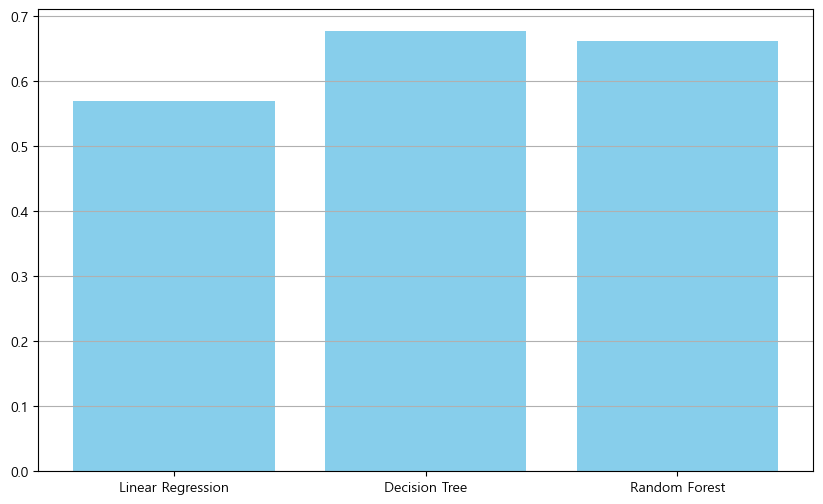

In [95]:
# 결과 시각화
r2_scores = [result["R2"] for result in results.values()]
model_names = list(results.keys())

plt.figure(figsize=(10,6))
plt.bar(model_names,r2_scores,color="skyblue")
plt.grid(axis='y')
plt.show()

In [96]:
# 4. 랜덤 포레스트 하이퍼파라미터 튜닝 (옵션)
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5,10]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [98]:
print("\n최적 하이퍼파라미터:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
tuned_rf_y_pred = best_rf_model.predict(X_test)


최적 하이퍼파라미터: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


In [99]:
# 튜닝된 모델 평가
tuned_rf_mse = mean_squared_error(y_test, tuned_rf_y_pred)
tuned_rf_r2 = r2_score(y_test, tuned_rf_y_pred)
print(f"튜닝된 랜덤 포레스트 - MSE: {tuned_rf_mse:.2f}, R2: {tuned_rf_r2:.2f}")

튜닝된 랜덤 포레스트 - MSE: 28.63, R2: 0.66


2025-03-17 15:15:50.361 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-17 15:15:50.592 
  command:

    streamlit run c:\pythonEdu\.venv\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-17 15:15:50.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()